In [1]:
import torch
from torch.utils.data import Dataset
import numpy as np
import json
import random
from PIL import Image
from matplotlib import cm
from IPython.display import display
import os

In [2]:
torch.manual_seed(10)
np.random.seed(10)
random.seed(10)
print(torch.cuda.is_available())

True


In [3]:
data_dir = "../Project1/data"
image_dir = "../Project1/data/images"

In [4]:
imgPIL = Image.open('../Project1/raw/005-9-01.jpg')
origwidth = imgPIL.size[0]
origheight = imgPIL.size[1]
print(origwidth, origheight)

3272 4544


# Pre Process

In [5]:
class MyData(Dataset):
    def __init__(self):
        file = "../Project1/raw/data.json"
        f = open(file)
        # 存储json 文件
        self.data = json.load(f)
        f.close()
        # 每张图片的 '../Project1/data/images\\005-9-01_0.jpg': 1',  1 代表有node) 或者 0 代表没有node
        self.labels = {}  # filename: label
        # 有node的box的width(横向)
        self.box_w = []
        # 有node的box的height(纵向)
        self.box_h = []
        # key为文件名，value为图片
        self.images = {}
        # key为文件名，value为对应这张图的所有的box的坐标(x_start, y_start, x_end, y_end (from 0 - 1))
        self.bounding_boxes = {}
        # 存储有 node 的图片以及没有node的图片
        self.x_train = []
        # 对应x_train，有 node 的图片存储 1，没 node 的图片存储0
        self.y_train = []
        self.gts = {}
        for key, val in self.data.items():
            try:
                imgPIL = Image.open("../Project1/raw/" + val["filename"])
                origwidth = imgPIL.size[0]
                origheight = imgPIL.size[1]
                imgPIL = imgPIL.resize((1280, 1280), Image.LANCZOS)
                image = torch.Tensor(np.asarray(imgPIL) / 255)
                self.images[val["filename"]] = image
                gt = torch.zeros((image.shape[0:2]))
                box_data = []  # x_center, y_center, width, height (from 0 - 1)
                for k2, v2 in val["regions"].items():
                    rectdata = v2["shape_attributes"]
                    # 横向(x轴)的起始位置
                    x1 = int(np.floor(1280 * float(rectdata["x"]) / origwidth))
                    # 纵向(y轴)的起始位置
                    y1 = int(np.floor(1280 * float(rectdata["y"]) / origheight))
                    # 横向(x轴)的终止位置
                    x2 = int(
                        np.ceil(
                            1280 * float(rectdata["x"] + rectdata["width"]) / origwidth
                        )
                    )
                    # 纵向(y轴)的终止位置
                    y2 = int(
                        np.ceil(
                            1280
                            * float(rectdata["y"] + rectdata["height"])
                            / origheight
                        )
                    )
                    gt[y1:y2, x1:x2] = 1
                    # box_data: ([包含node的横向起始位置, 包含node的纵向起始位置, 包含node的横向终止位置, 包含node的纵向终止位置])
                    box_data.append([x1, y1, x2, y2])
                    self.box_w.append(x2 - x1)
                    self.box_h.append(y2 - y1)
                self.gts[val["filename"]] = gt
                self.bounding_boxes[val["filename"]] = box_data
                print(
                    "File: {}; number: {}".format(val["filename"], len(val["regions"]))
                )
            except IOError:
                print("File not found: {}".format(val["filename"]))

    def gen_train_data(self):
        i = 0
        for filename in self.images:
            image = self.images[filename]
            box_data = self.bounding_boxes[filename]
            gt = self.gts[filename]
            for x1, y1, x2, y2 in box_data:
                cropped = image[y1 : min(y2, 1280), x1 : min(x2, 1280), :]
                cropped_img = Image.fromarray(np.uint8((cropped.numpy()) * 255))
                cropped_img_path = os.path.join(
                    image_dir, filename.split(".")[0] + "_" + str(i) + ".jpg"
                )
                i += 1
                # cropped_img.save(cropped_img_path)
                self.x_train.append(cropped_img)
                self.y_train.append(1)
                self.labels[cropped_img_path] = 1
            max_w, min_w, max_h, min_h = (
                max(self.box_w),
                min(self.box_w),
                max(self.box_h),
                min(self.box_h),
            )
            step = 10
            for k in range(2000):
                x = random.randint(0, 1280 - max_w)
                y = random.randint(0, 1280 - max_h)
                # randomly pick some windows that do not contain nodes
                x1, x2, y1, y2 = x, x + max_w, y, y + max_h
                if np.sum(np.array(gt[y1:y2, x1:x2])) == 0:
                    cropped = image[y1:y2, x1:x2, :]
                    cropped_img = Image.fromarray(np.uint8((cropped.numpy()) * 255))
                    cropped_img_path = os.path.join(
                        image_dir, filename.split(".")[0] + "_" + str(i) + ".jpg"
                    )
                    i += 1
                    # cropped_img.save(cropped_img_path) no need to save
                    self.x_train.append(cropped_img)
                    self.y_train.append(0)
                    self.labels[cropped_img_path] = 0
                else:
                    k -= 1

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        d, g = self.imgs[idx], self.gts[idx].unsqueeze(0)
        return d, g, idx


In [6]:
data = MyData()

C:\Users\Yuxuan Zhu\AppData\Local\Temp\ipykernel_24740\3853218259.py:28: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  imgPIL = imgPIL.resize((1280, 1280), Image.LANCZOS)


File: 005-9-01.jpg; number: 276
File: 022-5-02.jpg; number: 10
File: 22-14-01.jpg; number: 261
File: W005-4-05.jpg; number: 133
File: W005-08-03.jpg; number: 426
File: W005-08-04.jpg; number: 271
File: W005-08-06.jpg; number: 199
File: W005-14-02.jpg; number: 18
File not found: W022-02-07.jpg
File: W022-04-04.jpg; number: 237
File: W022-07-03.jpg; number: 280
File not found: W022-16-05.jpg
File not found: W022-19-06.jpg
File not found: W035-11-05.jpg
File not found: W035-18-03.jpg
File not found: W035-19-06.jpg
File not found: W035-19-07.jpg
File not found: W035-20-02.jpg


In [7]:
data.gen_train_data()
data.images["005-9-01.jpg"].size()

torch.Size([1280, 1280, 3])

In [8]:
len(np.where(np.array(data.y_train)==0)[0])

17148

# Start Training

In [9]:
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.models as models
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import time
import copy

In [10]:
seed = 0
trans = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [11]:
from torch.nn.modules.pooling import MaxPool2d
class myNet(nn.Module):
    def __init__(self):
        super(myNet, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2),stride=2),
            nn.Conv2d(32, 64, kernel_size=2, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2),stride=2),
            nn.Conv2d(64, 128, kernel_size=2, stride=2, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2),stride=2),
            nn.Dropout(0.25),
            nn.Flatten(),
            nn.Linear(in_features=1152,out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512,out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128,out_features=1),
            # 最后变成 0-0.5之间的输出
            nn.Sigmoid(),
            )
        
    def forward(self, x):
        return self.layer(x)

In [12]:
class TrainDataset(Dataset):
    def __init__(self):
        self.x = []
        self.y = []

    def get_data(self,x_data,y_data):
        """ 
        x_data(data.x_train): 存储了包含 node 的图片以及不包含node的图片
        y_data(data.y_train): 与x_data一一对应, 包含 node 的图片的对应位置存储 1, 不包含 node 的图片的对应位置存储0
        """
        for im in x_data:
            self.x.append(trans(im))
        for l in y_data:
            self.y.append(torch.tensor(l, dtype=torch.float32))
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

    def __len__(self):
        return len(self.y)

In [13]:
net = myNet()
criterion = nn.BCELoss()
optimizer_ft = optim.Adam(net.parameters(), lr=0.002)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
device = "cpu"

In [14]:
net

myNet(
  (layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.25, inplace=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=1152, out_features=512, bias=True)
    (12): ReLU()
    (13): Linear(in_features=512, out_features=128, bias=True)
    (14): ReLU()
    (15): Linear(in_features=128, out_features=1, bias=True)
    (16): Sigmoid()
  )
)

In [15]:
train_data = TrainDataset()
train_data.get_data(data.x_train,data.y_train)

In [16]:
batch_size = 64
numTrain = int(len(train_data)*0.6)
numVal = int(len(train_data)*0.2)
numTest = len(train_data)-numTrain-numVal

In [17]:
train, val, test = random_split(train_data, [numTrain, numVal, numTest], generator=torch.Generator().manual_seed(seed))
trainloader = DataLoader(train, batch_size=batch_size,shuffle=True)
valloader = DataLoader(val, batch_size=batch_size,shuffle=False)
testloader = DataLoader(test, batch_size=batch_size,shuffle=False)
torch.save(trainloader, os.path.join(data_dir,"trainloader.pt"))
torch.save(valloader, os.path.join(data_dir,"valloader.pt"))
torch.save(testloader, os.path.join(data_dir,"testloader.pt"))

In [18]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            running_loss = 0.0
            running_corrects = 0
            correct = 0
            if phase == 'train':
                model.train()  # Set model to training mode
                for inputs, labels in trainloader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    # zero the parameter gradients
                    optimizer.zero_grad()
                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs).view(-1)
                        loss = criterion(outputs, labels)
                        # backward + optimize
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                        correct +=  (outputs.detach().numpy().round() == labels.detach().numpy()).sum().item()
                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                print('train Accuracy:{:.4f}'.format(correct/len(trainloader.dataset)))
                scheduler.step()
                epoch_loss = running_loss / len(train_data)
            else:
                with torch.no_grad():
                    model.eval()   # Set model to evaluate mode
                    for inputs, labels in valloader:
                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        # zero the parameter gradients
                        optimizer.zero_grad()
                        # forward
                        # track history if only in train
                        with torch.set_grad_enabled(phase == 'train'):
                            outputs = model(inputs).view(-1)
                            loss = criterion(outputs, labels)
                            correct +=  (outputs.detach().numpy().round() == labels.detach().numpy()).sum().item()
                        # statistics
                        running_loss += loss.item() * inputs.size(0)
                epoch_loss = running_loss / len(train_data)
                print('val Accuracy:{:.4f}'.format(correct/len(valloader.dataset)))
            # Iterate over data.

            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))
            # deep copy the model
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    # load best model weights
    # model.load_state_dict(best_model_wts)
    return model

In [19]:
model = train_model(net, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------


KeyboardInterrupt: 

# Save model + Test Model

In [ ]:
torch.save(model,os.path.join("./model.pt"))


In [20]:
model = torch.load("./model.pt")
model.eval()
correct = 0
""" 
通过 outputs.detach().numpy().round()[i][0] == labels.detach().numpy()[i] 判断label是否匹配
"""
with torch.no_grad():
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        # print("innputs are", inputs.size())
        # print("labels are", labels)
        outputs = model(inputs.to(device))
        # print("原 output", outputs)
        # print(outputs.view(-1))
        for i in range(len(outputs.detach().numpy().round())):
            # print(
            #     "pred:{},label:{}, correct:{}".format(
            #         outputs.detach().numpy().round()[i][0],
            #         labels.detach().numpy()[i],
            #         outputs.detach().numpy().round()[i][0]
            #         == labels.detach().numpy()[i],
            #     )
            # )
            if outputs.detach().numpy().round()[i][0] == labels.detach().numpy()[i]:
                correct += 1
    print("accuracy: {}".format(correct / len(testloader.dataset)))


accuracy: 0.998961847910719


# Detection

## SIFT

In [21]:
import math
import time

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Circle
from scipy.ndimage.filters import gaussian_laplace, rank_filter
from skimage import color, io, transform


# convert images to grayscale
# rescale the intensities to between 0 and 1 (simply divide them by 255 should do the trick)
def read_img(IMG_NAME):
    img = cv.imread(IMG_NAME)
    origheight,origwidth,_ = img.shape
    img = cv.resize(img,(1280,1280))
    img = color.rgb2gray(img).astype(float)
    return img,origheight,origwidth

# Creating the Laplacian filter
# Pay careful attention to setting the right filter mask size.


def laplace_filter(img, sigma):
    filtered = sigma * sigma * gaussian_laplace(img, sigma=sigma)
    return filtered


# nonmaximum suppression in scale space
# you may find functions scipy.ndimage.filters.rank_filter or scipy.ndimage.filters.generic_filter useful
def nonmax_suppress(scale_space, max_scale_space, n, threshold):

    h, w, n = scale_space.shape
    compare_scale_space = np.zeros((h, w, n))

    for i in range(h):
        for j in range(w):
            max_value = max(max_scale_space[i, j, :])
            max_index = np.where(max_scale_space[i, j, :] == max_value)[0][0]
            if max_value >= threshold and max_value == scale_space[i, j, max_index]:
                compare_scale_space[i, j, max_index] = max_value

    return compare_scale_space


def find_blobs(compare_scale_space, sigma, k):

    cx = []
    cy = []
    rad = []
    h, w, n = compare_scale_space.shape
    for layer in range(n):
        for i in range(h):
            for j in range(w):
                if compare_scale_space[i, j, layer] != 0:
                    cx.append(j)
                    cy.append(i)
                    blob_radius = sigma * k ** layer
                    rad.append(blob_radius)

    return cx, cy, rad


def detect_blobs_downsample(img_name, grey_img, org_img, sigma, n, k):
    print(grey_img.shape)
    h, w = grey_img.shape
    scale_space = np.zeros((h, w, n))
    max_scale_space = np.zeros((h, w, n))
    start_time = time.time()

    for i in range(n):
        scaling = 1.0 / (k ** (i))
        downsampled = transform.resize(
            grey_img, (int(scaling * h), int(scaling * w)), anti_aliasing=True)
        filtered = laplace_filter(downsampled, sigma)
        upsampled = transform.resize(
            np.square(filtered), (h, w),  anti_aliasing=True)
        scale_space[:, :, i] = upsampled
        max_scale_space[:, :, i] = rank_filter(
            scale_space[:, :, i], rank=-1, size=(5, 5))

    compare_scale_space = nonmax_suppress(
        scale_space, max_scale_space, n, 0.01)
    cx, cy, rad = find_blobs(compare_scale_space, sigma, k)

    # create keypoints
    kp = [cv.KeyPoint(cx[i], cy[i], rad[i]) for i in range(len(cx))]

    circle_img = cv.drawKeypoints(
        org_img, kp, org_img, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imsave(f'{img_name}_circle_detect.jpg', circle_img)

    window = org_img
    color = (255, 0, 0)
    keypoints_num = len(cx)
    result = []
    for i in range(keypoints_num):
        radius = rad[i]

        start_x, start_y = math.floor(
            cx[i] - radius / 2), math.floor(cy[i] - radius / 2)
        end_x, end_y = math.floor(
            cx[i] + radius / 2), math.floor(cy[i] + radius / 2)

        if start_x < 0 or start_y < 0 or end_x >= w or end_y >= h:
            continue

        # 横向是 x 轴，纵向是 y 轴
        cv.rectangle(
            window, (start_x, start_y), (end_x, end_y), color, 1)

        result.append((start_x, start_y, end_x, end_y))

    plt.imsave(f'{img_name}_window.jpg', window)

    print("sigma is ", sigma)
    print("Num of key points are ", len(kp))
    print("Time taken:", time.time() - start_time)
    return cx,cy,rad


C:\Users\Yuxuan Zhu\AppData\Local\Temp\ipykernel_24740\2689392938.py:8: DeprecationWarning: Please use `gaussian_laplace` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_laplace, rank_filter
C:\Users\Yuxuan Zhu\AppData\Local\Temp\ipykernel_24740\2689392938.py:8: DeprecationWarning: Please use `rank_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_laplace, rank_filter


In [22]:
model = torch.load('./model.pt')

In [23]:
def select_candidates(file_name):
    sigma = 5
    n = 4
    threshold = 1.5
    raw_path = "../Project1/raw/"
    img_name = raw_path+file_name
    grey_img,h,w = read_img(img_name)
    org_img = cv.imread(img_name)
    org_img = cv.resize(org_img,(1280,1280))
    cx,cy,rad = detect_blobs_downsample(
        img_name, grey_img, org_img, sigma, n, threshold)
    return cx,cy,rad,h,w

## Load candidate windows into Predict Dataset

In [24]:
class PredictDataset(Dataset):
    def __init__(self):
        self.x = []
        self.h = []
        self.w = []
        self.x_center = []
        self.y_center = []
        self.origheight = 0
        self.origwidth = 0

    def get_data(self, file_name):
        cx, cy, rad, origheight, origwidth = select_candidates(file_name)
        self.origheight = origheight
        self.origwidth = origwidth
        imgPIL = Image.open("../Project1/raw/" + file_name)
        imgPIL = imgPIL.resize((1280, 1280), Image.LANCZOS)
        image = torch.Tensor(np.asarray(imgPIL) / 255)
        for i in range(len(cx)):
            # for each location
            x_center, y_center, radius = cx[i], cy[i], rad[i]
            for h in range(int(radius), 25, 2):
                for w in range(int(radius), 25, 2):
                    if h / w > 2 or w / h > 2:
                        continue
                    y1, y2, x1, x2 = (
                        max(0, int(y_center - h / 2)),
                        min(1280, int(y_center + h / 2)),
                        max(0, int(x_center - w / 2)),
                        min(1280, int(x_center + w / 2)),
                    )
                    cropped = image[y1:y2, x1:x2, :]
                    cropped_img = Image.fromarray(np.uint8((cropped.numpy()) * 255))
                    self.x.append(trans(cropped_img))
                    self.h.append(h)
                    self.w.append(w)
                    self.x_center.append(x_center)
                    self.y_center.append(y_center)

    def __getitem__(self, i):
        return self.x[i], self.h[i], self.w[i], self.x_center[i], self.y_center[i]

    def __len__(self):
        return len(self.x)


In [25]:
pdata = PredictDataset()

In [26]:
pdata.get_data("005-9-01.jpg")

(1280, 1280)
sigma is  5
Num of key points are  888
Time taken: 12.186318635940552


C:\Users\Yuxuan Zhu\AppData\Local\Temp\ipykernel_24740\2250352797.py:16: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  imgPIL = imgPIL.resize((1280, 1280), Image.LANCZOS)


In [27]:
predloader = DataLoader(pdata, batch_size=batch_size,shuffle=False)

## Run Prediction with classifier

In [28]:
model.eval()
bbox = {}
with torch.no_grad():
    for inputs, hs, ws, x_centers, y_centers in predloader:
        outputs = model(inputs.to(device))
        for i in range(len(outputs)):
            output = outputs[i]
            # print("output is ", output)
            if output.detach().numpy().round() == 0:
                continue
            h = int(hs[i])
            w = int(ws[i])
            x_center = int(x_centers[i])
            y_center = int(y_centers[i])
            if bbox.get((x_center, y_center)) == None:
                bbox[(x_center, y_center)] = (output, h, w)
            elif bbox[(x_center, y_center)][0] < output:
                bbox[(x_center, y_center)] = (output, h, w)


## Show prediction results

In [29]:
imgPIL = Image.open('../Project1/raw/005-9-01.jpg')
origwidth = imgPIL.size[0]
origheight = imgPIL.size[1]
imgPIL = imgPIL.resize((1280,1280),Image.LANCZOS)
image = torch.Tensor(np.asarray(imgPIL)/255)
gt = torch.zeros((image.shape[0:2]))
for x,y in bbox:
    score,h,w = bbox[(x,y)]
    # x1 = int(np.floor(pdata.origwidth*(x-w/2)/1280))
    # y1 = int(np.floor(pdata.origheight*(y-h/2)/1280))
    # x1 = int(np.floor(pdata.origwidth*(x+w/2)/1280))
    # y1 = int(np.floor(pdata.origheight*(y+h/2)/1280))
    x1 = int(np.floor(x-w/2))
    y1 = int(np.floor(y-h/2))
    x2 = int(np.floor(x+w/2))
    y2 = int(np.floor(y+h/2))
    gt[y1:y2,x1:x2] = 1

gtimg = Image.fromarray(np.uint8(cm.gist_earth(gt.numpy())*255))
detection = Image.blend(imgPIL.convert("RGBA"),gtimg.convert("RGBA"),0.5)

C:\Users\Yuxuan Zhu\AppData\Local\Temp\ipykernel_24740\3548668087.py:4: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  imgPIL = imgPIL.resize((1280,1280),Image.LANCZOS)


### calculate mAP

In [30]:
import csv

def writeDetection(filename, detect_points):
    file = open(f"./input/detections.csv", "w+")
    
    lines = "ImageID,LabelName,Conf,XMin,XMax,YMin,YMax\n"
    file.write(lines)
    
    for score, x1, x2, y1, y2 in detect_points:
        int_score = score.item()
        # <class_name> score <left> <top> <right> <bottom>
        lines = f"{filename},node,{int_score},{x1},{x2},{y1},{y2}\n"
        file.write(lines)
    file.close()
    
def writeGroundTruth(filename, box_points):
    file = open(f"./input/annotations.csv", "w+")
    
    lines = "ImageID,LabelName,XMin,XMax,YMin,YMax\n"
    file.write(lines)
    
    for x1, x2, y1, y2 in box_points:
        # <class_name> <left> <top> <right> <bottom>
        lines = f"{filename},node,{x1},{x2},{y1},{y2}\n"
        file.write(lines)
    file.close()
    

In [ ]:
data.bounding_boxes.keys()

dict_keys(['005-9-01.jpg', '022-5-02.jpg', '22-14-01.jpg', 'W005-4-05.jpg', 'W005-08-03.jpg', 'W005-08-04.jpg', 'W005-08-06.jpg', 'W005-14-02.jpg', 'W022-04-04.jpg', 'W022-07-03.jpg'])

In [31]:
filename = '005-9-01'
file_name_with_ext = filename + ".jpg"
true_points = []
for x1, y1, x2, y2 in data.bounding_boxes[file_name_with_ext]:
    true_points.append([x1 / origwidth, x2 / origwidth, y1 / origheight, y2 / origheight])
true_points.sort()
writeGroundTruth(filename, true_points)

detect_points = []
for x,y in bbox:
    score, h, w = bbox[(x,y)]
    x1 = int(np.floor(x-w/2))
    y1 = int(np.floor(y-h/2))
    x2 = int(np.floor(x+w/2))
    y2 = int(np.floor(y+h/2))
    detect_points.append([score, x1 / origwidth, x2 / origwidth, y1 / origheight, y2 / origheight])
detect_points.sort()
writeDetection(filename, detect_points)


In [32]:
from mAP import mean_average_precision_for_boxes
import pandas as pd
# Version 1
ann = pd.read_csv('input/annotations.csv')
det = pd.read_csv('input/detections.csv')
ann = ann[['ImageID', 'LabelName', 'XMin', 'XMax', 'YMin', 'YMax']].values
det = det[['ImageID', 'LabelName', 'Conf', 'XMin', 'XMax', 'YMin', 'YMax']].values
mean_ap, average_precisions = mean_average_precision_for_boxes(ann, det, 0.1)



Number of files in annotations: 1
Number of files in predictions: 1
Unique classes: 1
Detections length: 1
Annotations length: 1
node                           | 0.490552 |     276
mAP: 0.490552


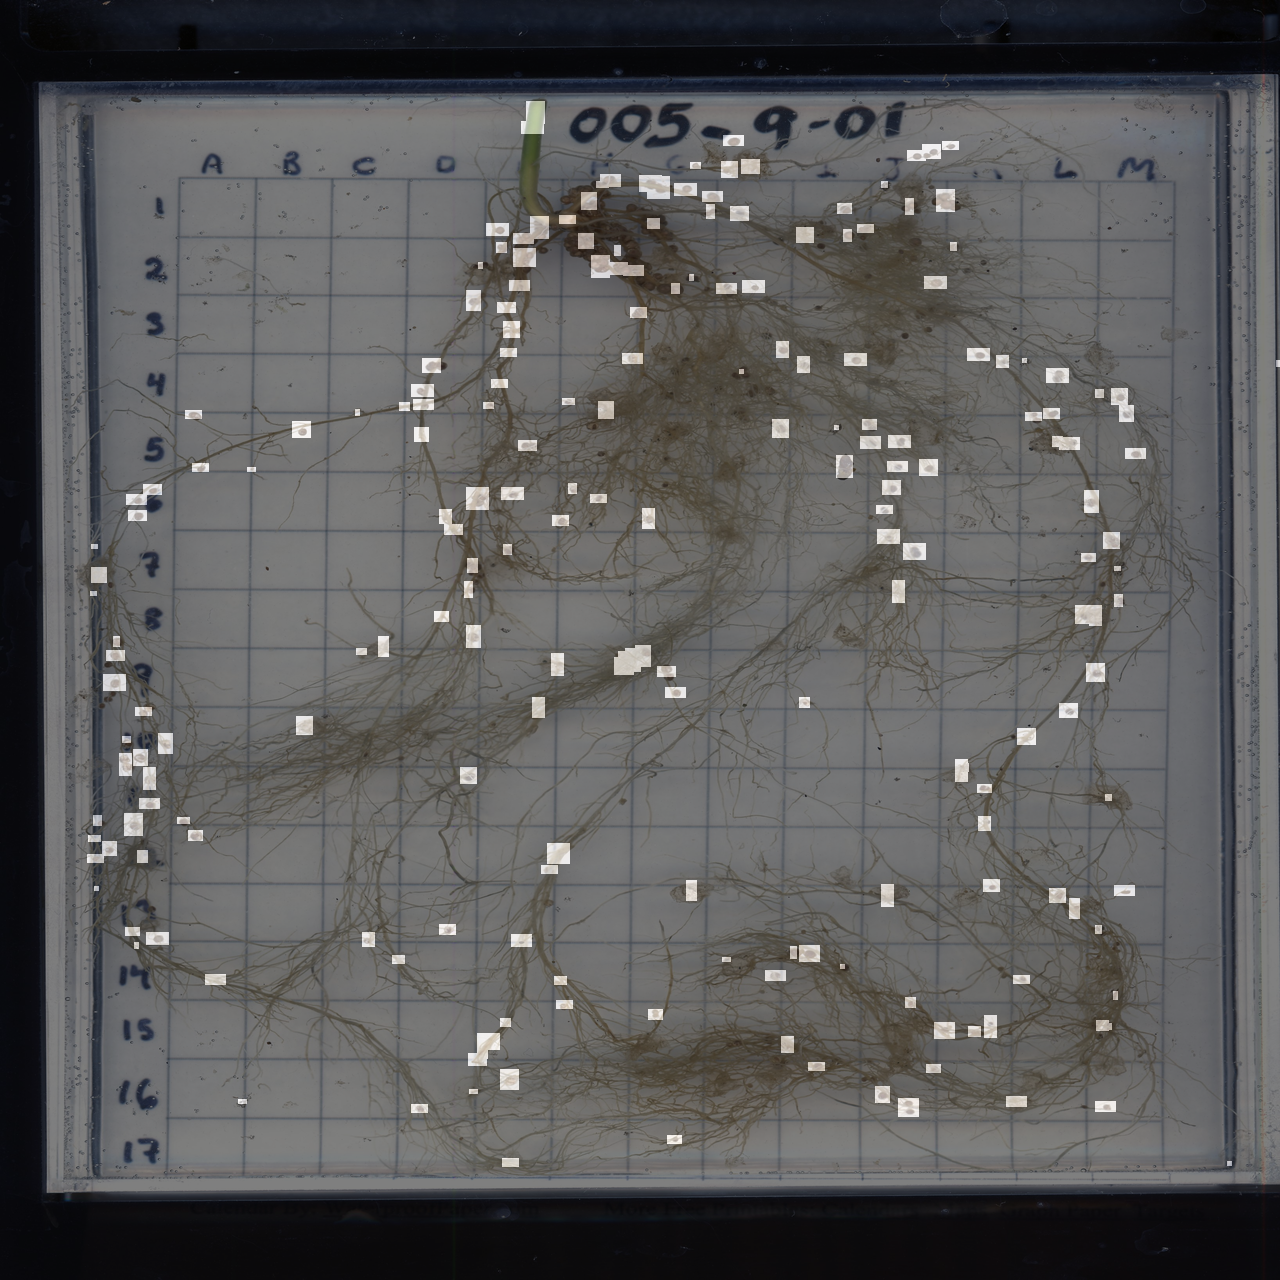

In [ ]:
display(detection)